# Soft Actor-Critic (SAC)

In [10]:
import torch
import gym
from gym.envs.classic_control import PendulumEnv
from gym.envs.mujoco import HalfCheetahEnv, HopperEnv, HumanoidEnv
from matplotlib import pyplot as plt

from src import SACConfig, RandomAgent, SACAgent, EnvWrapper, ReplayBuffer, SAC

In [11]:
config = SACConfig(
    env=HopperEnv,
    observation_dim=11,
    action_dim=3,
    temperature=1.0,
    total_train_steps=1_000_000,
    action_min=-1.0,
    action_max=1.0,
    max_episode_length=10_000,
    env_steps=1,
    training_steps=1,
    adjust_temperature=True,
    random_steps=10_000,
    initial_policy_steps=1_000,
    num_q_networks=2,
)

In [14]:
# Initialise Networks, Agents, Dataset and Environment
sac = SAC(config).cuda()
# sac = torch.load("humanoid.pt")
random_agent = RandomAgent(config)
agent = SACAgent(sac.policy_network, config)
dataset = ReplayBuffer(config)
env_wrapper = EnvWrapper(config, random_agent)

Creating window glfw


In [15]:
# Collect Initial Data
dataset.extend([env_wrapper.step() for _ in range(config.random_steps)])

env_wrapper.agent = agent
dataset.extend([env_wrapper.step() for _ in range(config.initial_policy_steps)])

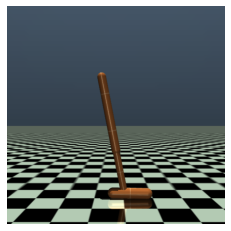

29.771373031091812

In [16]:
env_wrapper.test(render=True)

In [ ]:
# Train Model
test_returns = []
episode_idx = len(env_wrapper.ep_returns)
while env_wrapper.total_steps < config.total_train_steps:
    for _ in range(config.env_steps):
        dataset.extend([env_wrapper.step()])

    for batch_idx in range(config.training_steps):
        states, actions, rewards, next_states, is_done = dataset.sample()
        sac.train(states, actions, rewards, next_states, is_done)
    
    if (env_wrapper.total_steps % 500) < config.env_steps:
        test_return = env_wrapper.test(render=False)
        test_returns.append(test_return)
        print(f"Step: {env_wrapper.total_steps}\tEpisode: {env_wrapper.num_episodes}\tTest Return: {test_return:6.2f}\tTemperature: {sac.temperature.log_temperature.exp().item():8.4f}")
        torch.save(sac, "humanoid.pt")

Step: 11500	Episode: 472	Test Return:  95.93	Temperature:   0.8609
Step: 12000	Episode: 482	Test Return:  68.43	Temperature:   0.7433
Step: 12500	Episode: 490	Test Return:  45.75	Temperature:   0.6449
Step: 13000	Episode: 502	Test Return:  45.15	Temperature:   0.5618
Step: 13500	Episode: 512	Test Return: 152.23	Temperature:   0.4911
Step: 14000	Episode: 518	Test Return: 184.33	Temperature:   0.4323
Step: 14500	Episode: 524	Test Return: 198.80	Temperature:   0.3825
Step: 15000	Episode: 529	Test Return: 209.74	Temperature:   0.3384
Step: 15500	Episode: 534	Test Return: 223.72	Temperature:   0.3002
Step: 16000	Episode: 539	Test Return: 211.37	Temperature:   0.2664
Step: 16500	Episode: 544	Test Return: 258.09	Temperature:   0.2375
Step: 17000	Episode: 549	Test Return: 248.33	Temperature:   0.2130
Step: 17500	Episode: 553	Test Return: 264.64	Temperature:   0.1915
Step: 18000	Episode: 557	Test Return: 294.51	Temperature:   0.1718
Step: 18500	Episode: 561	Test Return: 363.52	Temperature:   0.

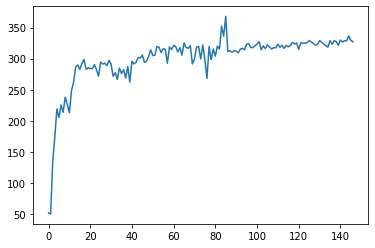

In [8]:
plt.plot(test_returns)

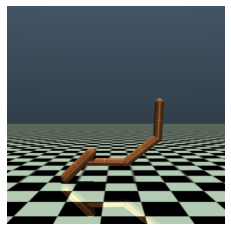

331.2472227834746

In [9]:
env_wrapper.test(render=True)